In [138]:
import numpy as np
import tensorflow as tf
import keras.backend as K
import keras as ker
from keras.layers import Input, Dense, Flatten, Reshape, GaussianNoise, Activation, Subtract
from keras.layers import LSTM, GRU, SimpleRNN, TimeDistributed, Multiply, Add, Concatenate, LayerNormalization, Lambda
from keras.layers.normalization import BatchNormalization
from keras.layers.wrappers import  Bidirectional
from keras.models import Model


%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# start to learn code
def create_fcnn_model(encoding_dim, input_dim, sigma):
    # step activation
    def bpsk_activation(x):
        return K.sign(x - 0.5)
    
    def step_activation(x):
        return K.sign(x)
    
    # Энкодер
    input_layer = Input(shape=(input_dim,))
    x = Dense(encoding_dim*3, activation='relu')(input_layer)
    x = Dense(encoding_dim*2, activation='relu')(x)
    x = Dense(encoding_dim, activation='sigmoid')(x)
    
    # BPSK
    # encoded = Activation(bpsk_activation)(x)
    
    # Noise
    input_noise = Input(shape=(encoding_dim,))
    noised = GaussianNoise(sigma)(input_noise, training=True)
    
    # Декодер
    input_encoded = Input(shape=(encoding_dim,))
    x = Dense(encoding_dim * 2, activation='relu')(input_encoded)
    x = Dense(encoding_dim * 3, activation='relu')(x)
    decoded = Dense(input_dim, activation='sigmoid')(x)
    
    # Модели
    encoder = Model(input_layer, encoded, name="encoder")
    noise = Model(input_noise, noised, name = "noise");
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_layer, decoder(noise(encoder(input_layer))), name="autoencoder")
    return encoder, decoder, autoencoder, noise


In [2]:
def int2bits(i, padding):
    return np.array(list(bin(i)[2:].zfill(padding)), dtype=int) 

In [3]:
def ber(X_pred, X_train):
    
    l = ( X_pred == X_train).sum()
    
    n = X_train.shape[0] * X_train.shape[1]

    return 1 - l / n

In [4]:
def hard(arr, threshold=0.5):
    return arr > threshold 

In [5]:
def get_sigma(snr):
    return 10 ** (-snr * 1.0/20)

In [145]:
# LEARN
# start to learn code
def create_gru_model(coderate, input_dim, sigma):
    # step activation
    def bpsk_activation(x):
        return K.sign(x - 0.5)
    
    def scale_activation(x):
        return 2 * (x - 0.5)
    
    def normalize(x):
        x_mean, x_var = tf.nn.moments(x, [0])
        x = (x - x_mean)*1.0 / tf.sqrt(x_var)
        
        return x
    
    enc_gru_units = 25
    dec_gru_units = 100
    # Энкодер
    x = Input(shape=(input_dim, 1))
    gru_enc1 = GRU(name='enc_gru_1', units=enc_gru_units, activation='tanh', return_sequences=True)
    gru_enc2 = GRU(name='enc_gru_2', units=enc_gru_units, activation='tanh', return_sequences=True)
    output_enc = Dense(coderate, activation='linear')
    norm = Lambda(normalize)
    
    encoded = norm(output_enc(gru_enc2(gru_enc1(x))))
    # BPSK
    # encoded = Activation(bpsk_activation)(encoded)
    #encoded = Activation(scale_activation)(encoded)
    # Noise
    input_noise = Input(shape=(input_dim, coderate))
    # noise = GaussianNoise(sigma)(K.zeros(shape=(input_dim, coderate)), training=True)
    # noised = Add()([input_noise, noise])
    noised = GaussianNoise(sigma)(input_noise, training=True)
    
    # Декодер
    y = Input(shape=(input_dim, coderate))
    gru_dec11 = GRU(name='dec_gru_11', units=dec_gru_units, activation='tanh', return_sequences=True)
    gru_dec12 = GRU(name='dec_gru_12', units=dec_gru_units, activation='tanh', return_sequences=True)
    gru_dec21 = GRU(name='dec_gru_21', units=dec_gru_units, activation='tanh', return_sequences=True)
    gru_dec22 = GRU(name='dec_gru_22', units=dec_gru_units, activation='tanh', return_sequences=True)
    concat = Concatenate(axis=2)
    output_dec = Dense(1, activation='sigmoid')
    
    one = gru_dec12(gru_dec11(y))
    two = gru_dec22(gru_dec21(y))
    decoded = output_dec(concat([one, two]))
    
    # Модели
    encoder = Model(x, encoded, name="encoder")
    encoder.summary()
    noise = Model(input_noise, noised, name = "noise");
    noise.summary()
    decoder = Model(y, decoded, name="decoder")
    decoder.summary()
    autoencoder = Model(x, decoder(noise(encoder(x))), name="autoencoder")
    return encoder, decoder, autoencoder, noise

coderate = 2
k = 10
total_count = 2 ** k;
sigma = get_sigma(2)

X_train = np.array([int2bits(i, k) for i in range(total_count)])
X_train = X_train.reshape((total_count, k, 1))
enc, dec, autoencoder, noise = create_gru_model(coderate, k, sigma)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=128,
                shuffle=True)

X_pred = autoencoder.predict(X_train)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_75 (InputLayer)        [(None, 10, 1)]           0         
_________________________________________________________________
enc_gru_1 (GRU)              (None, 10, 25)            2100      
_________________________________________________________________
enc_gru_2 (GRU)              (None, 10, 25)            3900      
_________________________________________________________________
dense_40 (Dense)             (None, 10, 2)             52        
_________________________________________________________________
lambda_2 (Lambda)            (None, 10, 2)             0         
Total params: 6,052
Trainable params: 6,052
Non-trainable params: 0
_________________________________________________________________
Model: "noise"
_________________________________________________________________
Layer (type)                 Output Shape 

In [45]:
ber(hard(X_pred), X_train)

0.48720703125

In [11]:


def simulate_sigma(k, enc, dec, sigma, batch_count=100, batch_size=256):
    err = 0.0;
    for i in range(batch_count):
        X = np.random.randint(2, size=(batch_size, k, 1))
       
        Y = enc.predict(X)
        Y_noised= Y + np.random.normal(loc=0.0, scale=sigma, size=Y.shape)
        X_pred = dec.predict(Y_noised)
        err += ber(hard(X_pred), X)
        
    err /= batch_count
    return err

def simulate_model_fixed_snr(k, enc, dec, snr_arr):
    ber_arr = []
    for snr in snr_arr:
        sigma = get_sigma(snr)
        err = simulate_sigma(k, enc, dec, sigma)
        ber_arr.append(err)
    
    return ber_arr


In [140]:
snr_arr = [0, 1, 2, 3, 4]
ber_fixed_arr = simulate_model_fixed_snr(k, enc, dec, snr_arr)

In [58]:
def simulate_repetition_sigma(k, coderate, sigma):
    batch_size = 256
    batch_count = 100
    
    err = 0.0
    for i in range(batch_count):
        X = np.random.randint(2, size=(batch_size, k, 1))
        rep = np.ones(shape=(coderate, 1))
        Y = np.kron(X, rep)
        Y[Y == 0] = -1
        Y_noised = Y + np.random.normal(loc=0.0, scale=sigma, size=Y.shape)
        
        # decoding
        X_pred = np.zeros(shape=(batch_size, k, 1))
        for j in range(batch_size):
            for l in range(k):
                temp = 0.0
                for t in range(coderate):
                    temp += Y_noised[j, l * coderate + t, 0]
                X_pred[j, l, 0] = 1 if temp > 0 else 0
        
        err += ber(X_pred, X)
    err /= batch_count
    return err

def simulate_repetition(k, coderate, snr_arr):
    ber_arr = []
    for snr in snr_arr:
        sigma = get_sigma(snr)
        err = simulate_repetition_sigma(k, coderate, sigma)
        ber_arr.append(err)
    
    return ber_arr

rep_arr = simulate_repetition(k, coderate, snr_arr)

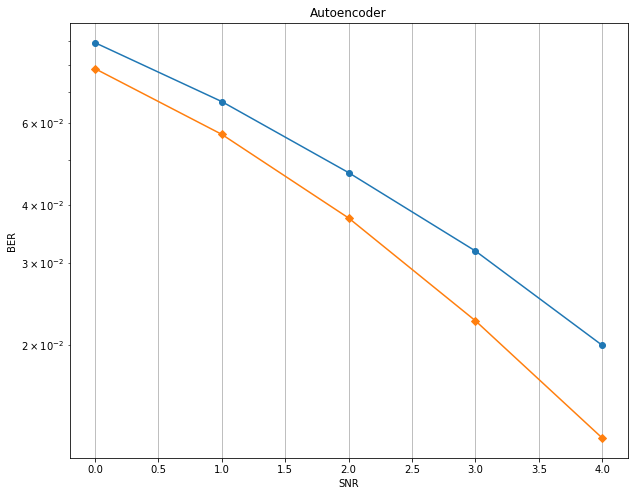

In [146]:
plt.figure(figsize=(10,8))
plt.plot(snr_arr, ber_fixed_arr, '-o', snr_arr, rep_arr, '-D');
plt.title("Autoencoder")
plt.xlabel("SNR")
plt.grid(True)
plt.ylabel("BER")
plt.yscale('log')
plt.xscale('linear')

In [143]:
v = enc.predict(int2bits(234, k).reshape(1, k, 1))[0,:,:]

e = tf.constant(v, dtype=float)
print(e)
x_mean, x_var = tf.nn.moments(e, [0, 1])
tf.print(x_var)

tf.Tensor(
[[nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]], shape=(10, 2), dtype=float32)
-nan


In [81]:
x = tf.constant([[1,2],[3,4],[5,6]], dtype=float)
x_mean, x_var = tf.nn.moments(x,[0, 1])
x = (x-x_mean)*1.0/tf.sqrt(x_var)

tf.print(x)
np.linalg.norm(x)

[[-1.46385 -0.87831]
 [-0.29277 0.29277]
 [0.87831 1.46385]]


2.4494896

In [118]:
s = tf.constant([[1,2],[3,4],[5,6]], dtype=float)


norm = LayerNormalization(axis=[0, 1])
o = norm(s)
tf.print(norm(s))
x_mean, x_var = tf.nn.moments(o, [0])
tf.print(x_var)

[[-1.46359921 -0.878159523]
 [-0.292719841 0.292719841]
 [0.878159523 1.46359921]]
[0.913972318 0.913972318]


In [130]:
x = Input(shape=(3, 2))
norm = LayerNormalization(axis=[1,2])
encoded = norm(x)
encoder = Model(x, encoded, name="encoder22")
encoder.summary()

t = np.array([[1,2], [3,4], [5,6]]).reshape(1, 3, 2)
r = encoder.predict(t)
np.std(r)

Model: "encoder22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_61 (InputLayer)        [(None, 3, 2)]            0         
_________________________________________________________________
layer_normalization_31 (Laye (None, 3, 2)              12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


0.99982864